In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import io, base64, os, json, re
import pandas as pd
import pandas_datareader.data as web
import datetime
import numpy as np

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import matplotlib.transforms as mtransforms
import datetime
import math

In [2]:
def gather_data(data_codes, start, 
                end = datetime.datetime.today(), freq = "M"):
    i = 0
    # dct.items() calls key and value that key points to
    for key, val in data_codes.items():
        if i == 0:
            # Create dataframe for first variable, then rename column
            df = web.DataReader(val, "fred", start, end).resample(freq).mean()
            df.rename(columns = {val:key}, inplace = True) 
            # setting i to None will cause the next block of code to execute,
            # placing data within df instead of creating a new dataframe for
            # each variable
            i = None
        else:
            # If dataframe already exists, add new column
            df[key] = web.DataReader(val, "fred", start, end).resample(freq).mean()

    return df

In [3]:
data_codes  = {"Base: Total ($ Mil)": "BOGMBASE",
               "Base: Currency in Circulation ($ Mil)": "WCURCIR",
               # Assets
               "Balance Sheet: Total Assets ($ Mil)": "WALCL",
               "Balance Sheet Securities, Prem-Disc, Repos, and Loans ($ Mil)": "WSRLL",
               "Balance Sheet: Securities Held Outright ($ Mil)": "WSHOSHO",
               ### breakdown of securities holdings ###
               "Balance Sheet: U.S. Treasuries Held Outright ($ Mil)":"WSHOTSL",
               "Balance Sheet: Federal Agency Debt Securities ($ Mil)" : "WSHOFADSL",
               "Balance Sheet: Mortgage-Backed Securities ($ Mil)": "WSHOMCB",
               # other forms of lending
               "Balance Sheet: Repos ($ Mil)": "WORAL",
               "Balance Sheet: Central Bank Liquidity Swaps ($ Mil)" : "SWPT",
               "Balance Sheet: Direct Lending ($ Mil)" : "WLCFLL",
               # unamortized value of securities held (due to changes in interest rates)
               "Balance Sheet: Unamortized Security Premiums ($ Mil)": "WUPSHO",
               # Liabilities
               "Balance Sheet: Total Liabilities ($ Mil)" : "WLTLECL",
               "Balance Sheet: Federal Reserve Notes Outstanding ($ Mil)" : "WLFN",
               "Balance Sheet: Reverse Repos ($ Mil)": "WLRRAL",
               ### Major share of deposits 
               "Balance Sheet: Excess Reserves ($ Mil)": "EXCSRESNW",
               "Balance Sheet: Required Reserves ($ Mil)": "RESBALREQW",
               "Balance Sheet: Total Reserves ($ Mil)": "WRESBAL",
               "Balance Sheet: Deposits from Dep. Institutions ($ Mil)":"WLODLL",
               "Balance Sheet: U.S. Treasury General Account ($ Mil)": "WDTGAL",
               "Balance Sheet: Other Deposits ($ Mil)": "WOTHLB",
               "Balance Sheet: All Deposits ($ Mil)": "WLDLCL",
               # Interest Rates
               "Federal Funds Target (Pre-Crisis)": "DFEDTAR",
               "Federal Funds (Upper) Target":"DFEDTARU",
               "Effective Federal Funds Rate":"DFF",
               "Interest on Excess Reserves":"IOER",
               # Req Reserves and Vault Cash
               "Vault Cash ($ Mil)": "TLVAULTW",
               "Vault Cash Used as Req. ($ Mil)": "VAULT",
               }
               
# Select start and end dates
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime.today()

# freq refers to data frequency. Choose "D", "W", "M", "Q", "A"
# a number may also be place in front of a letter. "2D" indicates
#       alternating days
fed_data = gather_data(data_codes = data_codes, start = start, 
                   end = end, freq = "M")

In [4]:
data = pd.read_csv("data 1.csv")

In [5]:
data

,Date,Base: Currency in Circulation ($ Mil),Balance Sheet: Total Assets ($ Mil),Effective Federal Funds Rate,Adj Close,Log Total Asset,Currency in Circulation/Total Asset,Log Stock Price,Unemployment Rate
0,1/31/2000,594.68,0.00,5.45,1394.46,0.000000,0.000000,7.240263,4.1
1,2/29/2000,566.14,0.00,5.73,1366.42,0.000000,0.000000,7.219949,4.0
2,3/31/2000,563.71,0.00,5.85,1498.58,0.000000,0.000000,7.312273,3.8
3,4/30/2000,564.73,0.00,6.02,1452.43,0.000000,1.000000,7.280993,4.0
4,5/31/2000,565.84,0.00,6.27,1420.60,0.000000,0.000000,7.258835,4.0
...,...,...,...,...,...,...,...,...,...
257,6/30/2021,2178.84,8026555.20,0.08,4297.50,15.898266,0.000271,8.365789,5.4
258,7/31/2021,2186.13,8190356.75,0.10,4395.26,15.918468,0.000267,8.388282,5.2
259,8/31/2021,2187.63,8291893.25,0.09,4522.68,15.930789,0.000264,8.416860,4.8
260,9/30/2021,2194.90,8418612.40,0.08,4307.54,15.945956,0.000261,8.368122,4.6


In [6]:
data.dtypes

Date                                      object
Base: Currency in Circulation ($ Mil)    float64
Balance Sheet: Total Assets ($ Mil)      float64
Effective Federal Funds Rate             float64
Adj Close                                float64
Log Total Asset                          float64
Currency in Circulation/Total Asset      float64
Log Stock Price                          float64
Unemployment Rate                        float64
dtype: object

In [7]:
# set the index to the date column
data = data.set_index('Date')

In [8]:
data

,Base: Currency in Circulation ($ Mil),Balance Sheet: Total Assets ($ Mil),Effective Federal Funds Rate,Adj Close,Log Total Asset,Currency in Circulation/Total Asset,Log Stock Price,Unemployment Rate
Date,,,,,,,,
1/31/2000,594.68,0.00,5.45,1394.46,0.000000,0.000000,7.240263,4.1
2/29/2000,566.14,0.00,5.73,1366.42,0.000000,0.000000,7.219949,4.0
3/31/2000,563.71,0.00,5.85,1498.58,0.000000,0.000000,7.312273,3.8
4/30/2000,564.73,0.00,6.02,1452.43,0.000000,1.000000,7.280993,4.0
5/31/2000,565.84,0.00,6.27,1420.60,0.000000,0.000000,7.258835,4.0
...,...,...,...,...,...,...,...,...
6/30/2021,2178.84,8026555.20,0.08,4297.50,15.898266,0.000271,8.365789,5.4
7/31/2021,2186.13,8190356.75,0.10,4395.26,15.918468,0.000267,8.388282,5.2
8/31/2021,2187.63,8291893.25,0.09,4522.68,15.930789,0.000264,8.416860,4.8


In [9]:
data_new = data.drop(['Base: Currency in Circulation ($ Mil)', 'Balance Sheet: Total Assets ($ Mil)', 'Adj Close'], axis=1)

In [10]:
data_new

,Effective Federal Funds Rate,Log Total Asset,Currency in Circulation/Total Asset,Log Stock Price,Unemployment Rate
Date,,,,,
1/31/2000,5.45,0.000000,0.000000,7.240263,4.1
2/29/2000,5.73,0.000000,0.000000,7.219949,4.0
3/31/2000,5.85,0.000000,0.000000,7.312273,3.8
4/30/2000,6.02,0.000000,1.000000,7.280993,4.0
5/31/2000,6.27,0.000000,0.000000,7.258835,4.0
...,...,...,...,...,...
6/30/2021,0.08,15.898266,0.000271,8.365789,5.4
7/31/2021,0.10,15.918468,0.000267,8.388282,5.2
8/31/2021,0.09,15.930789,0.000264,8.416860,4.8


In [11]:
data_new = data_new.loc['1/31/2009':'10/31/2021']

In [12]:
data_new

,Effective Federal Funds Rate,Log Total Asset,Currency in Circulation/Total Asset,Log Stock Price,Unemployment Rate
Date,,,,,
1/31/2009,0.15,14.525435,0.000436,6.716449,8.3
2/28/2009,0.22,14.447648,0.000475,6.599993,8.7
3/31/2009,0.18,14.501045,0.000454,6.681946,9.0
4/30/2009,0.15,14.568579,0.000425,6.771718,9.4
5/31/2009,0.18,14.573726,0.000424,6.823438,9.5
...,...,...,...,...,...
6/30/2021,0.08,15.898266,0.000271,8.365789,5.4
7/31/2021,0.10,15.918468,0.000267,8.388282,5.2
8/31/2021,0.09,15.930789,0.000264,8.416860,4.8


In [13]:
from statsmodels.tsa.stattools import adfuller
X1 = data_new["Effective Federal Funds Rate"].values
result = adfuller(X1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -2.462716
p-value: 0.124811
Critical Values:
	1%: -3.476
	5%: -2.882
	10%: -2.577
Failed to Reject Ho - Time Series is Non-Stationary


In [14]:
data_new.isnull().sum()

Effective Federal Funds Rate           0
Log Total Asset                        0
Currency in Circulation/Total Asset    0
Log Stock Price                        0
Unemployment Rate                      0
dtype: int64

Section Three: Check for Perfect Multicollinearity
One of the first things we can do after loading our data is to validate one of the assumptions of our model; in this case, we will be checking for multicollinearity.

What is multicollinearity?
One of the assumptions of our model is that there isn't any Perfect multicollinearity. Multicollinearity is where one of the explanatory variables is highly correlated with another explanatory variable. In essence, one of the X variables is almost perfectly correlated with another or multiple X variables.

What is the problem with multicollinearity?
The problem with multicollinearity, from a math perspective, is that the coefficient estimates themselves tend to be unreliable. Additionally, the standard errors of slope coefficients become artificially inflated. Because the standard error is used to help calculate the p-value, this leads to a higher probability that we will incorrectly conclude that a variable is not statistically significant.

Another way we can look at this problem is by using an analogy. Imagine we ask you to go to a concert and determine who was the best singer. This task would become very challenging if you couldn't distinguish the two singers because they are singing at the same volume. The idea is the same in our analysis, how can we determine which variable is playing a role in our model if we can't distinguish the two? The problem is we can't.

Now a little correlation is fine, but if it gets too high, we can effectively distinguish the two variables. The other issue that arises is that when we have highly correlated exploratory variables is that, in a sense, we have duplicates. This means that we can remove one of them and we haven't lost anything; the model would still perform the same.

How to test for multicollinearity?
Because of these drawbacks, we should always check for multicollinearity in our data. Now, in the step above I purposely pull in variables that I knew would be highly correlated with each other; that way we could see some examples of variables that would cause some issues.

The first thing we can do is create a correlation matrix using the corr() function; this will create a matrix with each variable having its correlation calculated for all the other variables. Keep in mind, if you travel diagonally down the matrix all the associations should be one, as it is calculating the correlation of the variable with itself. When we have multiple variables as we do, I sometimes prefer to use a correlation heatmap this way I can quickly identify the highly correlated variables, by just looking for the darker colors.

,Effective Federal Funds Rate,Log Total Asset,Currency in Circulation/Total Asset,Log Stock Price,Unemployment Rate
Effective Federal Funds Rate,1.000000,0.105593,0.488608,0.429083,-0.624635
Log Total Asset,0.105593,1.000000,-0.748307,0.926251,-0.527493
Currency in Circulation/Total Asset,0.488608,-0.748307,1.000000,-0.469760,0.162723
Log Stock Price,0.429083,0.926251,-0.469760,1.000000,-0.664910
Unemployment Rate,-0.624635,-0.527493,0.162723,-0.664910,1.000000


<AxesSubplot:>

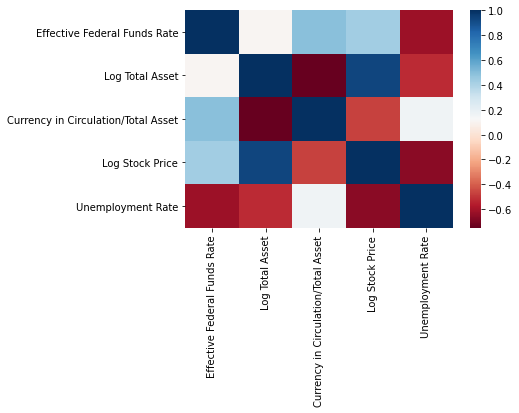

In [15]:
# calculate the correlation matrix
corr = data_new.corr()

# display the correlation matrix
display(corr)

# plot the correlation heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu')

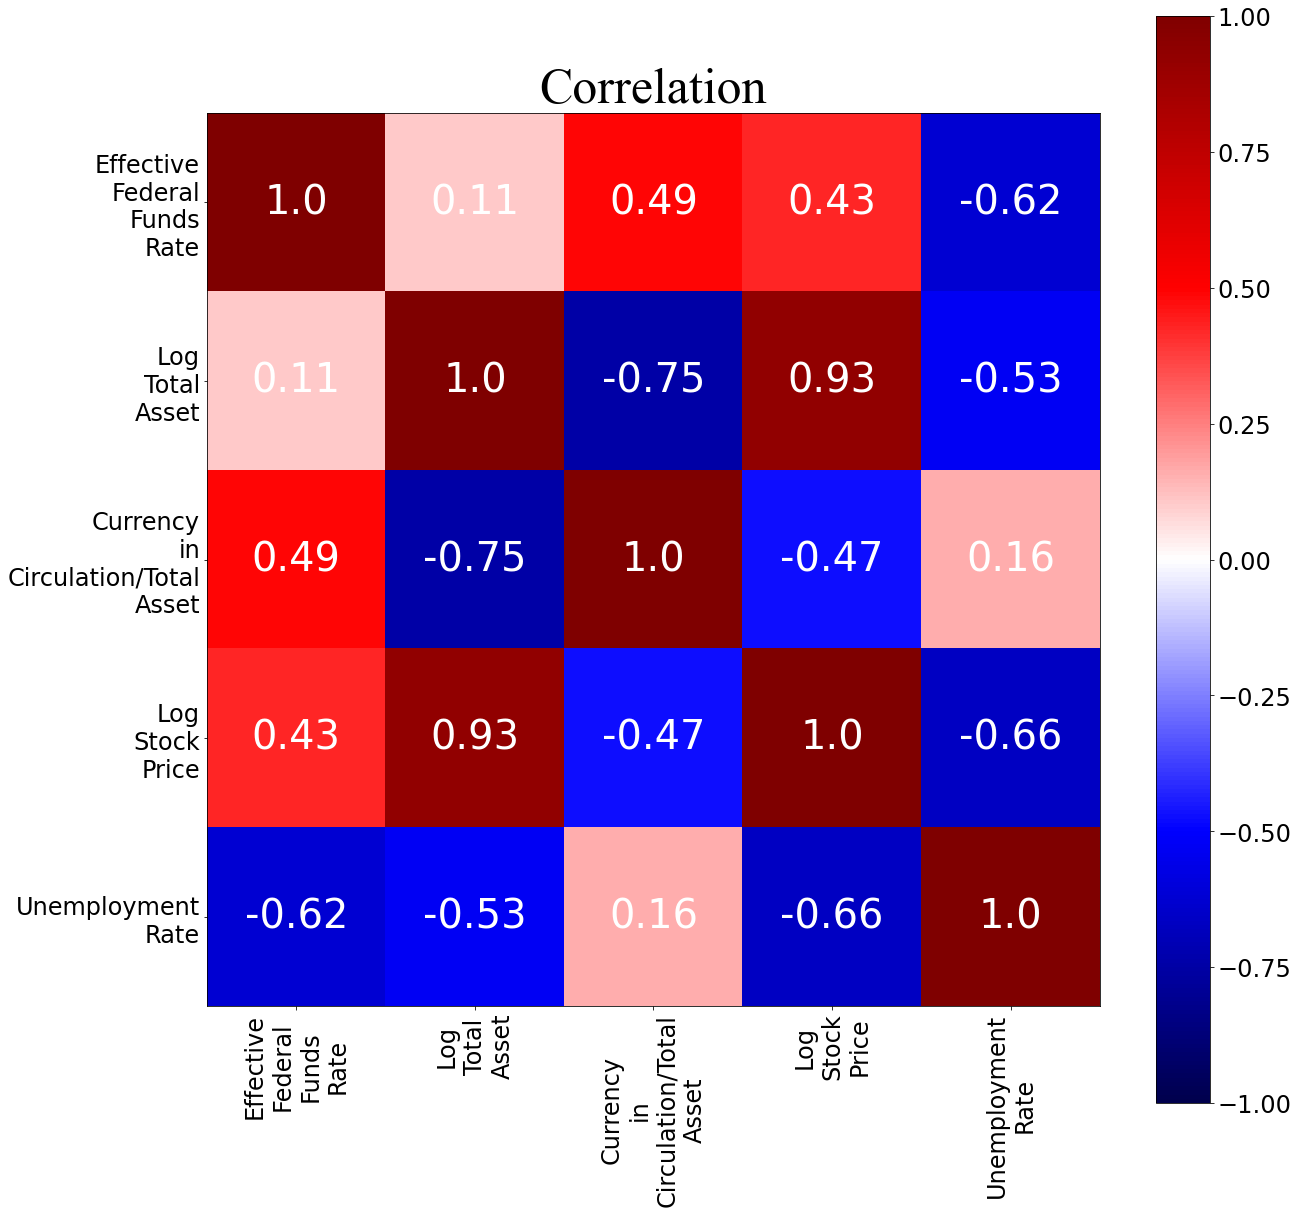

In [16]:
from datlib.plots import *
corr_matrix_heatmap(data_new.corr())

Looking at the heatmap along with the correlation matrix we can identify a few highly correlated variables. For example, if you look at the correlation between birth_rate and pop_growth it ends up at almost .98. This is an extremely high correlation and marks it as a candidate to be removed. Logically it makes sense that these two are highly correlated; if you're having more babies, then the population should be increasing.

However, we should be more systematic in our approach to removing highly correlated variables. One method we can use is the variance_inflation_factor which is a measure of how much a particular variable is contributing to the standard error in the regression model. When significant multicollinearity exists, the variance inflation factor will be huge for the variables in the calculation.

A general recommendation is that if any of our variables come back with a value of 5 or higher, then they should be removed from the model. I decided to show you how the VFI comes out before we drop the highly correlated variables and after we remove the highly correlated variables. Going forward in the tutorial we will only be using the econ_df_after data frame.

In [17]:
# get the summary
desc_df = data_new.describe()

# add the standard deviation metric
desc_df.loc['+3_std'] = desc_df.loc['mean'] + (desc_df.loc['std'] * 3)
desc_df.loc['-3_std'] = desc_df.loc['mean'] - (desc_df.loc['std'] * 3)

# display it
desc_df

,Effective Federal Funds Rate,Log Total Asset,Currency in Circulation/Total Asset,Log Stock Price,Unemployment Rate
count,154.000000,154.000000,154.000000,154.000000,154.000000
mean,0.524740,15.156902,0.000359,7.578002,6.544805
std,0.711445,0.362283,0.000056,0.423018,2.294154
min,0.050000,14.447648,0.000259,6.599993,3.500000
25%,0.090000,14.866175,0.000307,7.218270,4.600000
50%,0.150000,15.241900,0.000361,7.630131,6.100000
75%,0.622500,15.314242,0.000403,7.905924,8.375000
max,2.420000,15.957519,0.000475,8.434980,14.800000
+3_std,2.659076,16.243750,0.000526,8.847056,13.427267
-3_std,-1.609596,14.070055,0.000192,6.308947,-0.337657


In [18]:
# filter the data frame to remove the values exceeding 3 standard deviations
data_remove_df = data_new[(np.abs(stats.zscore(data_new)) < 3).all(axis=1)]

# what rows were removed
data_new.index.difference(data_remove_df.index)

Index(['3/31/2020'], dtype='object', name='Date')

In [19]:
# define our input variable (X) & output variable

X = data_new.drop('Log Stock Price', axis = 1)
Y = data_new[['Log Stock Price']]

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=1)

# create a Linear Regression model object
regression_model = LinearRegression()

# pass through the X_train & y_train data set
regression_model.fit(X_train, y_train)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

LinearRegression()

In [20]:
# let's grab the coefficient of our model and the intercept
intercept = regression_model.intercept_[0]
coefficent = regression_model.coef_[0][0]

print("The intercept for our model is {:.4}".format(intercept))
print('-'*100)

# loop through the dictionary and print the data
for coef in zip(X.columns, regression_model.coef_[0]):
    print("The Coefficient for {} is {:.2}".format(coef[0],coef[1]))

The intercept for our model is -13.58
----------------------------------------------------------------------------------------------------
The Coefficient for Effective Federal Funds Rate is 0.063
The Coefficient for Log Total Asset is 1.3
The Coefficient for Currency in Circulation/Total Asset is 2.6e+03
The Coefficient for Unemployment Rate is -0.0096


In [21]:
# define our intput
X2 = sm.add_constant(X)

# create a OLS model
model = sm.OLS(Y, X2)

# fit the data
est = model.fit()

In [22]:
_, pval, __, f_pval = diag.het_breuschpagan(est.resid, est.model.exog)
print(pval, f_pval)
print('-'*100)

# print the results of the test
if pval > 0.05:
    print("For the Breusch-Pagan's Test")
    print("The p-value was {:.4}".format(pval))
    print("We fail to reject the null hypthoesis, so there is no heterosecdasticity.")

else:
    print("For the Breusch-Pagan's Test")
    print("The p-value was {:.4}".format(pval))
    print("We reject the null hypthoesis, so there is heterosecdasticity.")

1.6875902222211417e-05 6.708593617365058e-06
----------------------------------------------------------------------------------------------------
For the Breusch-Pagan's Test
The p-value was 1.688e-05
We reject the null hypthoesis, so there is heterosecdasticity.


The number of lags will be 10
----------------------------------------------------------------------------------------------------
The lowest p-value found was 3.491e-36
We reject the null hypthoesis, so there is autocorrelation.
----------------------------------------------------------------------------------------------------


C:\Users\HP\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


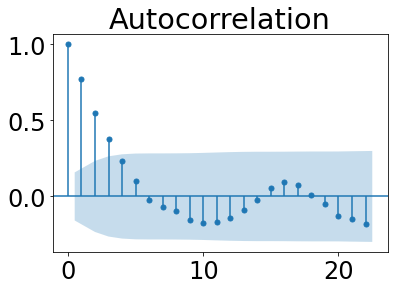

In [23]:
# test for autocorrelation
from statsmodels.stats.stattools import durbin_watson

# calculate the lag, optional
lag = min(10, (len(X)//5))
print('The number of lags will be {}'.format(lag))
print('-'*100)

# run the Ljung-Box test for no autocorrelation of residuals
# test_results = diag.acorr_breusch_godfrey(est, nlags = lag, store = True)
test_results = diag.acorr_ljungbox(est.resid, lags = lag)

# grab the p-values and the test statistics
ibvalue, p_val = test_results

# print the results of the test
if min(p_val) > 0.05:
    print("The lowest p-value found was {:.4}".format(min(p_val)))
    print("We fail to reject the null hypthoesis, so there is no autocorrelation.")
    print('-'*100)
else:
    print("The lowest p-value found was {:.4}".format(min(p_val)))
    print("We reject the null hypthoesis, so there is autocorrelation.")
    print('-'*100)

# plot autocorrelation
sm.graphics.tsa.plot_acf(est.resid)
plt.show()

In [24]:
y_var = ["Log Stock Price"]
x_vars = ["Log Total Asset",
         "Currency in Circulation/Total Asset",
         "Effective Federal Funds Rate",
         "Unemployment Rate"]
reg_vars = y_var + x_vars
reg_data = data[reg_vars].dropna()
reg_data

,Log Stock Price,Log Total Asset,Currency in Circulation/Total Asset,Effective Federal Funds Rate,Unemployment Rate
Date,,,,,
1/31/2000,7.240263,0.000000,0.000000,5.45,4.1
2/29/2000,7.219949,0.000000,0.000000,5.73,4.0
3/31/2000,7.312273,0.000000,0.000000,5.85,3.8
4/30/2000,7.280993,0.000000,1.000000,6.02,4.0
5/31/2000,7.258835,0.000000,0.000000,6.27,4.0
...,...,...,...,...,...
6/30/2021,8.365789,15.898266,0.000271,0.08,5.4
7/31/2021,8.388282,15.918468,0.000267,0.10,5.2
8/31/2021,8.416860,15.930789,0.000264,0.09,4.8


In [25]:
reg_data.corr()

,Log Stock Price,Log Total Asset,Currency in Circulation/Total Asset,Effective Federal Funds Rate,Unemployment Rate
Log Stock Price,1.000000,0.379568,-0.204783,-0.193854,-0.311260
Log Total Asset,0.379568,1.000000,-0.560952,-0.555311,0.235350
Currency in Circulation/Total Asset,-0.204783,-0.560952,1.000000,0.147557,-0.077404
Effective Federal Funds Rate,-0.193854,-0.555311,0.147557,1.000000,-0.561607
Unemployment Rate,-0.311260,0.235350,-0.077404,-0.561607,1.000000


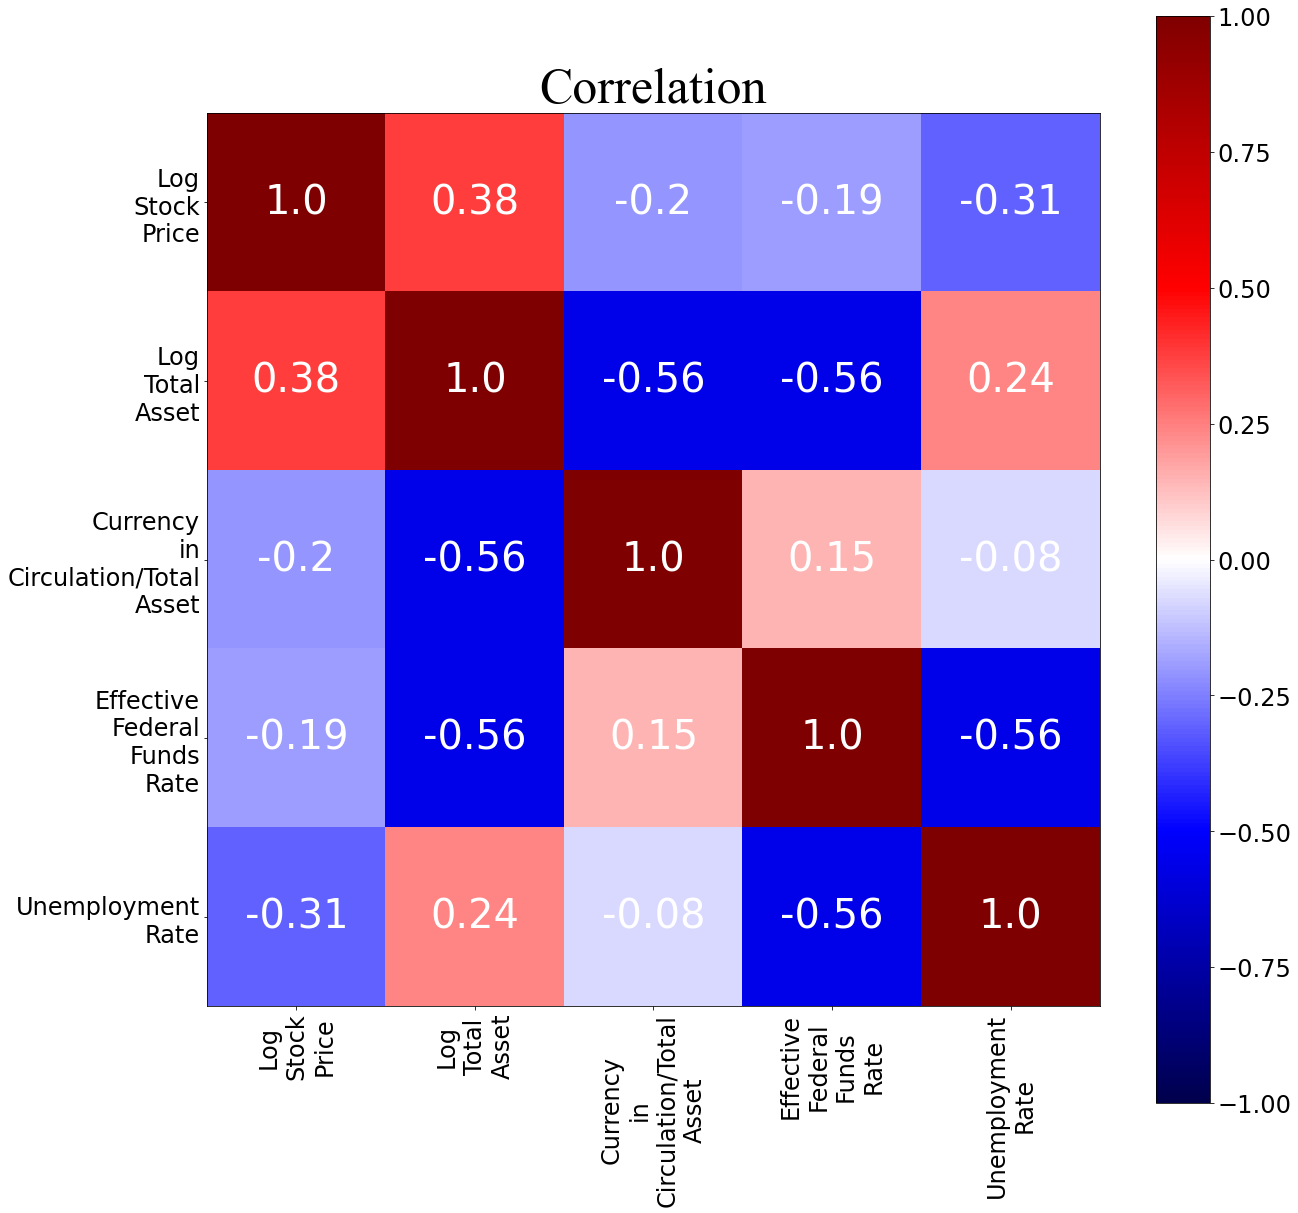

In [26]:
from datlib.plots import *
corr_matrix_heatmap(reg_data.corr())

In [27]:
reg_data.describe().round(2)

,Log Stock Price,Log Total Asset,Currency in Circulation/Total Asset,Effective Federal Funds Rate,Unemployment Rate
count,262.00,262.00,262.00,262.00,262.00
mean,7.38,12.71,0.52,1.65,5.97
std,0.42,5.05,2.34,1.89,1.95
min,6.60,0.00,0.00,0.05,3.50
25%,7.07,13.61,0.00,0.13,4.60
50%,7.25,14.68,0.00,1.01,5.45
75%,7.65,15.29,0.00,2.39,6.90
max,8.43,15.96,16.00,6.54,14.80


In [28]:
y = reg_data[y_var]
X = reg_data[x_vars]
X["Constant"]=1
results = sm.OLS(y,X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Log Stock Price   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                     37.71
Date:                Wed, 08 Dec 2021   Prob (F-statistic):           8.20e-25
Time:                        09:29:15   Log-Likelihood:                -81.411
No. Observations:                 262   AIC:                             172.8
Df Residuals:                     257   BIC:                             190.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Log Total Asset                         0.0258      0.006      4.232      0.000       0.014       0.038
Currency in Circulation/Total Asset    -0.0042      0.011     -0.385      0.701      -0.026       0.017
Effective Federal Funds Rate           -0.0754      0.016     -4.713      0.000      -0.107      -0.044
Unemployment Rate                      -0.1238      0.013     -9.582      0.000      -0.149      -0.098
Constant                                7.9149      0.141     56.248      0.000       7.638       8.192
==============================================================================
Omnibus:                       47.332   Durbin-Watson:                   0.073
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               94.752
Skew:                           0.917   Prob(JB):                     2.66e-21
Kurtosis:                       5.305   Cond. No.                         103.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
predictor = results.predict()
reg_data[y_var[0] + " Predictor"] = predictor

In [30]:
predictor

array([6.99646022, 6.98773101, 7.00344387, 6.96163416, 6.94702083,
       6.91895167, 6.91428596, 6.92935915, 6.9405533 , 6.92437128,
       6.94130719, 6.89129078, 6.94412415, 6.94328122, 6.96987537,
       6.99106581, 7.04042374, 7.01226555, 7.02407588, 6.98263701,
       7.02732922, 7.00395564, 7.05169155, 7.02547288, 7.07883167,
       7.02727004, 7.05407211, 7.00990239, 7.06494411, 7.00566841,
       7.07883167, 7.01456811, 7.07732389, 6.98482068, 7.07109413,
       7.45140026, 7.43898198, 7.43735318, 7.42581028, 7.41314544,
       7.38843592, 7.40384362, 7.43215772, 7.43059982, 7.44459135,
       7.46948456, 7.48264349, 7.4845621 , 7.49543848, 7.46971052,
       7.4952887 , 7.4955145 , 7.49553924, 7.50591552, 7.50113932,
       7.48815648, 7.46346385, 7.46385   , 7.45137118, 7.44673882,
       7.42525241, 7.43321656, 7.42347757, 7.42458699, 7.42044422,
       7.41765237, 7.4135329 , 7.38305249, 7.37418092, 7.36207179,
       7.35808519, 7.37121129, 7.34892274, 7.34614021, 7.33875

In [31]:
y_name = y_var[0]
y_hat = reg_data[y_name + " Predictor"]
y_mean = reg_data[y_name].mean()
y = reg_data[y_name]
y_hat, y_mean, y

(Date
 1/31/2000     6.996460
 2/29/2000     6.987731
 3/31/2000     7.003444
 4/30/2000     6.961634
 5/31/2000     6.947021
                 ...   
 6/30/2021     7.650349
 7/31/2021     7.674121
 8/31/2021     7.724712
 9/30/2021     7.750617
 10/31/2021    7.800434
 Name: Log Stock Price Predictor, Length: 262, dtype: float64,
 7.37619095845419,
 Date
 1/31/2000     7.240263
 2/29/2000     7.219949
 3/31/2000     7.312273
 4/30/2000     7.280993
 5/31/2000     7.258835
                 ...   
 6/30/2021     8.365789
 7/31/2021     8.388282
 8/31/2021     8.416860
 9/30/2021     8.368122
 10/31/2021    8.434980
 Name: Log Stock Price, Length: 262, dtype: float64)

In [32]:
# calcuate SSE, SSR, SST
reg_data["Residuals"] = y_hat.sub(y_mean)
reg_data["Residuals"]

Date
1/31/2000    -0.379731
2/29/2000    -0.388460
3/31/2000    -0.372747
4/30/2000    -0.414557
5/31/2000    -0.429170
                ...   
6/30/2021     0.274158
7/31/2021     0.297930
8/31/2021     0.348521
9/30/2021     0.374426
10/31/2021    0.424243
Name: Residuals, Length: 262, dtype: float64

In [33]:
reg_data["Squared Residuals"] = reg_data["Residuals"].pow(2)
reg_data["Squared Residuals"]

Date
1/31/2000     0.144195
2/29/2000     0.150901
3/31/2000     0.138940
4/30/2000     0.171857
5/31/2000     0.184187
                ...   
6/30/2021     0.075162
7/31/2021     0.088763
8/31/2021     0.121467
9/30/2021     0.140195
10/31/2021    0.179982
Name: Squared Residuals, Length: 262, dtype: float64

In [34]:
reg_data["Squared Errors"] = (y.sub(y_hat)) ** 2
reg_data["Squared Totals"] = (y.sub(y_mean)) ** 2
reg_data

,Log Stock Price,Log Total Asset,Currency in Circulation/Total Asset,Effective Federal Funds Rate,Unemployment Rate,Log Stock Price Predictor,Residuals,Squared Residuals,Squared Errors,Squared Totals
Date,,,,,,,,,,
1/31/2000,7.240263,0.000000,0.000000,5.45,4.1,6.996460,-0.379731,0.144195,0.059440,0.018477
2/29/2000,7.219949,0.000000,0.000000,5.73,4.0,6.987731,-0.388460,0.150901,0.053925,0.024411
3/31/2000,7.312273,0.000000,0.000000,5.85,3.8,7.003444,-0.372747,0.138940,0.095376,0.004085
4/30/2000,7.280993,0.000000,1.000000,6.02,4.0,6.961634,-0.414557,0.171857,0.101990,0.009063
5/31/2000,7.258835,0.000000,0.000000,6.27,4.0,6.947021,-0.429170,0.184187,0.097228,0.013773
...,...,...,...,...,...,...,...,...,...,...
6/30/2021,8.365789,15.898266,0.000271,0.08,5.4,7.650349,0.274158,0.075162,0.511855,0.979304
7/31/2021,8.388282,15.918468,0.000267,0.10,5.2,7.674121,0.297930,0.088763,0.510025,1.024328
8/31/2021,8.416860,15.930789,0.000264,0.09,4.8,7.724712,0.348521,0.121467,0.479069,1.082992


In [35]:
SSR = reg_data["Squared Residuals"].sum()
SSE = reg_data["Squared Errors"].sum()
SST = reg_data["Squared Totals"].sum()

SSR, SSE, SST

(16.76178187859492, 28.557592046172694, 45.31937392476627)

In [36]:
n = results.nobs
k = len(results.params)
estimator_variance = SSE / (n - k)
n,k,estimator_variance

(262.0, 5, 0.11111903519911553)

In [37]:
cov_matrix = results.cov_params()
cov_matrix

,Log Total Asset,Currency in Circulation/Total Asset,Effective Federal Funds Rate,Unemployment Rate,Constant
Log Total Asset,0.000037,0.000039,0.000054,0.000010,-0.000644
Currency in Circulation/Total Asset,0.000039,0.000121,0.000042,0.000010,-0.000693
Effective Federal Funds Rate,0.000054,0.000042,0.000256,0.000110,-0.001791
Unemployment Rate,0.000010,0.000010,0.000110,0.000167,-0.001317
Constant,-0.000644,-0.000693,-0.001791,-0.001317,0.019801


In [38]:
results.params

Log Total Asset                        0.025788
Currency in Circulation/Total Asset   -0.004234
Effective Federal Funds Rate          -0.075389
Unemployment Rate                     -0.123798
Constant                               7.914903
dtype: float64

In [39]:
parameters = {}
for x_var in X.keys():
    parameters[x_var] = {}
    parameters[x_var]["Beta"] = results.params[x_var]
    parameters[x_var]["Standard Error"] = cov_matrix.loc[x_var,x_var] ** (1/2)
    parameters[x_var]["t_stats"] = parameters[x_var]["Beta"] / parameters[x_var]["Standard Error"]

pd.DataFrame(parameters).T

,Beta,Standard Error,t_stats
Log Total Asset,0.025788,0.006093,4.232119
Currency in Circulation/Total Asset,-0.004234,0.011010,-0.384551
Effective Federal Funds Rate,-0.075389,0.015995,-4.713216
Unemployment Rate,-0.123798,0.012919,-9.582489
Constant,7.914903,0.140715,56.247678


In [40]:
r2 = SSR / SST
"R^2", r2

('R^2', 0.369859078512885)

In [41]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Log Stock Price   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                     37.71
Date:                Wed, 08 Dec 2021   Prob (F-statistic):           8.20e-25
Time:                        09:29:21   Log-Likelihood:                -81.411
No. Observations:                 262   AIC:                             172.8
Df Residuals:                     257   BIC:                             190.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Log Total Asset                         0.0258      0.006      4.232      0.000       0.014       0.038
Currency in Circulation/Total Asset    -0.0042      0.011     -0.385      0.701      -0.026       0.017
Effective Federal Funds Rate           -0.0754      0.016     -4.713      0.000      -0.107      -0.044
Unemployment Rate                      -0.1238      0.013     -9.582      0.000      -0.149      -0.098
Constant                                7.9149      0.141     56.248      0.000       7.638       8.192
==============================================================================
Omnibus:                       47.332   Durbin-Watson:                   0.073
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               94.752
Skew:                           0.917   Prob(JB):                     2.66e-21
Kurtosis:                       5.305   Cond. No.                         103.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

(array([-1.2, -1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

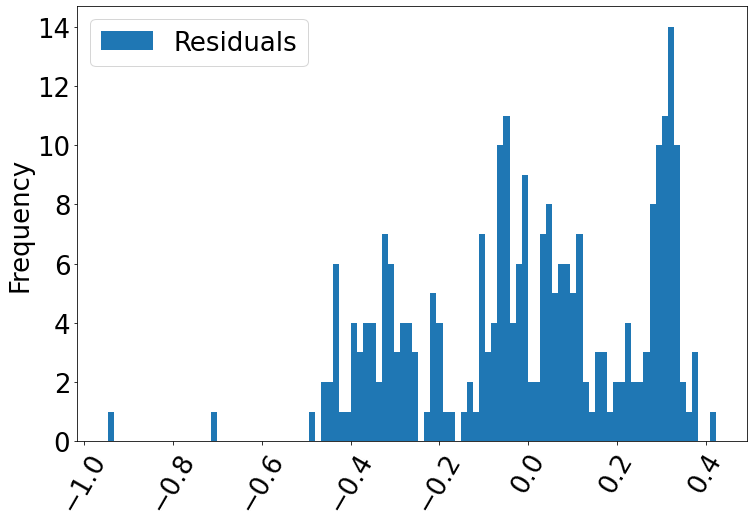

In [42]:
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size":26})
fig, ax = plt.subplots(figsize = (12,8))
reg_data[["Residuals"]].plot.hist(bins = 100, ax = ax)
plt.xticks(rotation=60)

<AxesSubplot:ylabel='Frequency'>

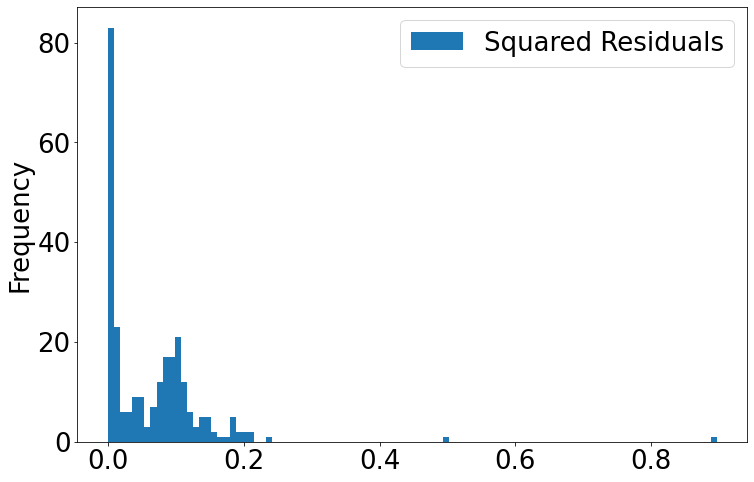

In [43]:
fig, ax = plt.subplots(figsize = (12,8))
reg_data[["Squared Residuals"]].plot.hist(bins =100, ax = ax)

In [44]:
betaEstimates = results.params
tStats = results.tvalues
pValues = results.pvalues
stdErrors = results.bse

resultsDict = {"Beta Estimates" : betaEstimates,
              "t-stats":tStats,
              "p-values":pValues,
              "Standard Errors":stdErrors}
resultsDF = pd.DataFrame(resultsDict)
resultsDF.round(3)

,Beta Estimates,t-stats,p-values,Standard Errors
Log Total Asset,0.026,4.232,0.000,0.006
Currency in Circulation/Total Asset,-0.004,-0.385,0.701,0.011
Effective Federal Funds Rate,-0.075,-4.713,0.000,0.016
Unemployment Rate,-0.124,-9.582,0.000,0.013
Constant,7.915,56.248,0.000,0.141


In [46]:
import statsmodels.api as sm

residuals = {}
for y_var in data_new.keys():
    X_vars = list(data_new.keys())
    X_vars.remove(y_var)
    X = data_new[X_vars]
    X["Constant"] = 1
    y = data_new[[y_var]]
    model = sm.OLS(y, X)
    results = model.fit()
    residuals[y_var] = results.resid
residuals = pd.DataFrame(residuals)

In [47]:
residuals

,Effective Federal Funds Rate,Log Total Asset,Currency in Circulation/Total Asset,Log Stock Price,Unemployment Rate
Date,,,,,
1/31/2009,-0.105914,0.121602,0.000036,-0.174211,-1.878815
2/28/2009,-0.244355,0.216128,0.000068,-0.287383,-2.852756
3/31/2009,-0.128894,0.159873,0.000048,-0.217995,-1.815832
4/30/2009,0.069485,0.095100,0.000024,-0.142179,-0.411940
5/31/2009,0.060932,0.061987,0.000016,-0.095754,-0.026772
...,...,...,...,...,...
6/30/2021,-0.405612,-0.002127,0.000010,0.045655,-0.455478
7/31/2021,-0.385757,-0.006487,0.000008,0.049595,-0.445437
8/31/2021,-0.443834,-0.018451,0.000007,0.067143,-0.722194


In [48]:
residuals.corr()[residuals.corr().abs() < 1].mul(-1).fillna(1).round(2)

,Effective Federal Funds Rate,Log Total Asset,Currency in Circulation/Total Asset,Log Stock Price,Unemployment Rate
Effective Federal Funds Rate,1.00,-0.08,0.51,0.30,-0.60
Log Total Asset,-0.08,1.00,-0.76,0.95,0.20
Currency in Circulation/Total Asset,0.51,-0.76,1.00,0.56,0.45
Log Stock Price,0.30,0.95,0.56,1.00,-0.16
Unemployment Rate,-0.60,0.20,0.45,-0.16,1.00


In [49]:
import random
import pingouin

In [50]:
data_new.pcorr().round(2)

,Effective Federal Funds Rate,Log Total Asset,Currency in Circulation/Total Asset,Log Stock Price,Unemployment Rate
Effective Federal Funds Rate,1.00,-0.08,0.51,0.30,-0.60
Log Total Asset,-0.08,1.00,-0.76,0.95,0.20
Currency in Circulation/Total Asset,0.51,-0.76,1.00,0.56,0.45
Log Stock Price,0.30,0.95,0.56,1.00,-0.16
Unemployment Rate,-0.60,0.20,0.45,-0.16,1.00


In [51]:
corr_matrix_heatmap(df.pcorr())

NameError: name 'df' is not defined

In [ ]:
pcorr_pvalues = {}

for y, Y in residuals.items():
    pcorr_pvalues[y] = {}
    for x, X in residuals.items():
        if x != y:
            pcorr_pvalues[y][x] = sm.OLS(Y,X).fit().pvalues[x]
        else:
            pcorr_pvalues[y][x] = np.NaN
pd.DataFrame(pcorr_pvalues).round(2)

In [ ]:
undirected_graph = {key:[] for key in df.keys()}
for x in undirected_graph:
    undirected_graph[x] = [y for y in data_new.keys() if y != x]
undirected_graph

In [ ]:
import copy
p_val = 0.01
def build_skeleton(data_new, undirected_graph):
    def check_remaining_controls(control_vars, undirected_graph, x, y, controls_used) :
        c_used = copy.copy(controls_used)
        for c_var in control_vars:
            if y not in undirected_graph[x]:
                break
            c_used.append(c_var)
            test = data_new.partial_corr(x = x, y = y, covar=c_used,
                                  method = "pearson")
            if test["p-val"].values[0] > p_val: 
                undirected_graph[x].remove(y)
                break
            else:
                remaining_controls = copy.copy(control_vars)
                remaining_controls.remove(c_var)
                check_remaining_controls(remaining_controls, undirected_graph, x, y, c_used)

    for x in df.keys():
        ys = undirected_graph[x]
        for y in data_new.keys():
            if x !=y:
                test = data_new.partial_corr(x=x,
                                      y=y,
                                      covar=None,
                                      method="pearson")
                if test["p-val"].values[0] > p_val:
                    undirected_graph[x].remove(y)
                else:
                    control_vars = [z for z in df.keys() if z !=y and z !=x]
                    check_remaining_controls(control_vars, undirected_graph, x, y, [])
    return undirected_graph

print(build_skeleton(data_new, undirected_graph))

C:\Users\HP\anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

def graph_DAG(undirected_graph, data_new, title = "DAG Structure"):
    pcorr_matrix = data_new.pcorr()
    graph = nx.Graph()
    edges = []
    edge_labels = {}
    for key in undirected_graph:
        for key2 in undirected_graph[key]:
            if (key2, key) not in edges:
                edge = (key.replace(" ","\n"), key2[0].replace(" ","\n"))
                edges.append(edge)
                edge_labels[edge] = str(round(pcorr_matrix.loc[key][key2],2))
    
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]
    
    fix, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    
    pos = nx.spring_layout(graph)
    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, 
                     pos, 
                     node_color=color_map, 
                     node_size = 1000,
                     with_labels=True,  
                     arrows=False,
                     font_size = 20, 
                     alpha = 1,
                     font_color = "black",
                     ax = ax)
    nx.draw_networkx_edge_labels(graph,
                                 pos,
                                 edge_labels=edge_labels,
                                 font_color='green',
                                 font_size=20)
    
    
    plt.show()
    
graph_DAG(undirected_graph, data_new)

In [52]:
import networkx as nx

AttributeError: module 'matplotlib.cbook' has no attribute 'iterable'

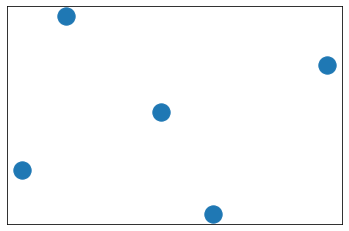

In [53]:
g1 = nx.DiGraph()
g1.add_edges_from([("Log Stock Price", "Log Total Asset"), ("Log Stock Price", "Unemployment Rate"), ("Log Stock Price", "Effective Federal Funds Rate"), ("Log Stock Price", "Currency in Circulation/Total Asset")])
plt.tight_layout()
nx.draw_networkx(g1, arrows=True)
plt.savefig("g1.png", format="PNG")
plt.clf()

AttributeError: module 'matplotlib.cbook' has no attribute 'iterable'

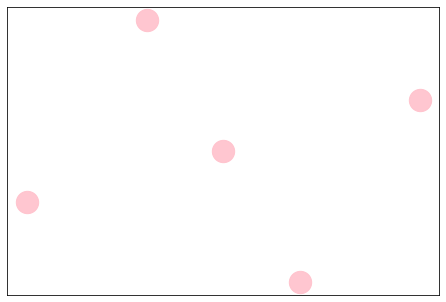

In [4]:
import matplotlib.pyplot as plt
import networkx as nx

edges = [['Effective Federal Funds Rate', 'Log Stock Price'], ['Log Stock Price', 'Log Total Asset'], ['Log Stock Price', 'Unemployment Rate'], ['Log Stock Price', 'Currency in Circulation/Total Asset']]
G = nx.Graph()
G.add_edges_from(edges)
pos = nx.spring_layout(G)
plt.figure()
nx.draw(
    G, pos, edge_color='black', width=1, linewidths=1,
    node_size=500, node_color='pink', alpha=0.9,
    labels={node: node for node in G.nodes()}
)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels={('Effective Federal Funds Rate', 'Log Stock Price'): 'AB', 
                 ('Log Stock Price', 'Log Total Asset'): 'BC', 
                 ('Log Stock Price', 'Unemployment Rate'): 'BD',
                 ('Log Stock Price', 'Currency in Circulation/Total Asset'): 'BE'},
    font_color='red'
)
plt.axis('off')
plt.show()
